## Загружаем необходимые библиотеки

In [40]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
%matplotlib inline

# для нормализации, стандартизации
from sklearn import preprocessing

# загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# загружаем библиотеку для анализа интенсивности настроения
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nadezdaoskina/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip3 freeze > requirements.txt

In [6]:
# загружаем данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

## Объединяем трейн и тест в один датасет

In [39]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/var/folders/8_/y936460960110gnpk46t3fw00000gn/T/ipykernel_13696/154621427.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [8]:
# изучим датасет на наличие пропусков и типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Имеются пропуски у признаков 'lat' и 'ing' - их нужно заполнить релевантными значениями

## Работаем с адресом отеля

In [9]:
# извлекаем признак страны из адреса
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['hotel_country'] = data['hotel_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
display(data['hotel_country'].value_counts())

print()

# извлекаем признак города из адреса 
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])
data['hotel_city'] = data['hotel_city'].apply(lambda x: 'London' if x == 'United' else x)
display(data['hotel_city'].value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [10]:
# кодируем признак страны с помощью OneHotEncoding
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

# кодируем признак города с помощью OneHotEncoding
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

In [11]:
# добавляем население страны
country_population = {
    'United Kingdom':68481129,'Netherlands':17198147,'France':65515838,
    'Spain':46785044,'Italy':60313823,'Austria':9093258
}
data['country_population'] = data['hotel_country'].map(country_population)

# добавляем население города
сity_population = {
    'Paris': 2139907, 'London': 9002488, 'Milan': 1374582,
    'Vienna': 1951354, 'Barcelona': 1636732, 'Amsterdam': 905234
}

data['сity_population'] = data['hotel_city'].map(сity_population)

# добавляем долю населения города к населению страны
data['%_city_pop_from_country_pop'] = data['сity_population'] / data['country_population']

In [12]:
# после извлечения полезных данных из адреса отеля, его можно удалить
data = data.drop(['hotel_address'], axis=1)
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,hotel_country_Austria,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna,country_population,сity_population,%_city_pop_from_country_pop
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,0,0,0,0,0,60313823,1374582,0.022790
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,1,0,0,0,0,17198147,905234,0.052636
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,0,0,0,1,0,0,0,46785044,1636732,0.034984


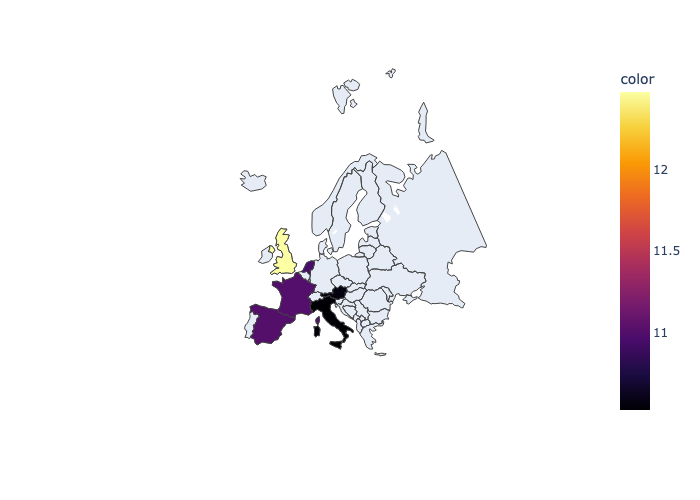

In [13]:
# посмотрим, как распределяются отели по странам
df_h = data.groupby('hotel_country')['hotel_name'].count()
fig = px.choropleth(
    locations=df_h.index,
    locationmode = "country names",
    scope='europe',
    color=np.log(df_h.values),
    color_continuous_scale=px.colors.sequential.Inferno)
fig.show("png")


Видим, что отели сосредоточены в шести странах: Великобритания, Испания, Франция, Нидерланды, Австрия, Италия.

## Работаем с пропусками в датасете

In [14]:
# заполним пропуски датасета, а именно признаков географической широты и долготы, нулями с целью последующей обработки
values = {
    'lat': 0,
    'lng': 0,
}
data = data.fillna(values)

# заполним координаты географической широты отеля релеватными координатами города, в котором находится отель
def lat_fillna(x):
    lat = x[0]
    city = x[1]
    if city == 'Paris' and lat == 0:
        return 48.8567
    elif city == 'Vienna' and lat == 0:
        return 48.2000
    elif city == 'Barcelona' and lat == 0:
        return 41.3833
    elif city == 'London' and lat == 0:
        return 51.5072
    elif city == 'Milan' and lat == 0:
        return 45.4666
    elif city == 'Amsterdam' and lat == 0:
        return 52.3666
    else:
        return lat
    
data['lat'] = data[['lat', 'hotel_city']].apply(lat_fillna, axis = 1)

# заполним координаты географической долготы отеля релеватными координатами города, в котором находится отель
def lng_fillna(x):
    lng = x[0]
    city = x[1]
    if city == 'Paris' and lng == 0:
        return 2.3508
    elif city == 'Vienna' and lng == 0:
        return 16.3666
    elif city == 'Barcelona' and lng == 0:
        return 2.1833
    elif city == 'London' and lng == 0:
        return 0.1275
    elif city == 'Milan' and lng == 0:
        return 9.1833
    elif city == 'Amsterdam' and lng == 0:
        return 4.9000
    else:
        return lng
    
data['lng'] = data[['lng', 'hotel_city']].apply(lng_fillna, axis = 1)

In [15]:
# убеждаемся в том, что все пропуски обработаны
data[data.lat.isna()]

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,hotel_country_Austria,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna,country_population,сity_population,%_city_pop_from_country_pop


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## Работаем с датой

In [17]:
# извлекаем месяц из даты отзыва ввиду возможного влияния сезонности
data['review_date'] = pd.to_datetime(data['review_date'])  
data['review_date_month'] = data['review_date'].dt.month.astype(int)

data = data.drop(['review_date'], axis=1)

# также извлекаем количество дней между датой проверки и датой очистки и преобразовываем к числовому типу данных
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')
data['days_since_review'].head()

0     13
1    234
2    616
3    656
4    444
Name: days_since_review, dtype: int64

In [18]:
# снова смотрим на датасет
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna,country_population,сity_population,%_city_pop_from_country_pop,review_date_month
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,1,0,0,0,0,0,60313823,1374582,0.022790,7
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,1,0,0,0,0,17198147,905234,0.052636,12
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,0,0,1,0,0,0,46785044,1636732,0.034984,11


## Обрабатываем теги

In [19]:
# напишем функцию для создания словаря с подсчетом тегов
unique_dic = {}
def make_unique_dic(x):
    x = x[3:-3].split(" ', ' ")
    for elem in x:
        if elem in unique_dic:
            unique_dic[elem] = unique_dic[elem] + 1
        else:
            unique_dic[elem] = 1
    return x

data['tags'].apply(make_unique_dic)

# получим датафрейм со всеми тегами и их частотой встречаемости
unique_tags = pd.DataFrame(unique_dic, index=['count']).transpose()
display(unique_tags)

,count
Leisure trip,417778
Couple,252294
Double Room,35207
Stayed 2 nights,133937
Group,65392
...,...
Executive Suite with River View,1
Family Room 6 Adults,1
Two Adjoining Rooms with Dock View Upper Deck,1
Westminster Suite with King Bed,1


In [20]:
# преобразуем строки тегов в списки тегов
data.tags = data.tags.apply(lambda x: x[3:-3].split(" ', ' "))
data['tags'].head(3)

0    [Leisure trip, Couple, Double Room, Stayed 2 n...
1    [Leisure trip, Group, Triple Room, Stayed 1 ni...
2    [Business trip, Solo traveler, Twin Room, Stay...
Name: tags, dtype: object

In [21]:
# выделим топ 20 тегов
top_tags = list(unique_tags.index[:20])
print(top_tags)

['Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights', 'Group', 'Triple Room', 'Stayed 1 night', 'Business trip', 'Solo traveler', 'Twin Room', 'Submitted from a mobile device', 'Ambassador Junior Suite', 'Classic Double or Twin Room', 'Standard Double or Twin Room', 'Queen Room', 'Executive Room', 'Stayed 3 nights', 'Double or Twin Room', 'Standard Triple Room', 'Superior Double Room']


In [22]:
# закодируем признак tags
for tag in top_tags:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

data = data.drop(['tags'], axis=1)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Submitted from a mobile device,Ambassador Junior Suite,Classic Double or Twin Room,Standard Double or Twin Room,Queen Room,Executive Room,Stayed 3 nights,Double or Twin Room,Standard Triple Room,Superior Double Room
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,0,0,0,0,0,0,0,0
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,0,0,0,0,0,0,0,0,0
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,1,0,0,0,0,0,0,0,0,0


## Работаем с признаком "страна рецензента"

In [23]:
# посмотрим, сколько всего уникальных признаков национальности
print(len(data['reviewer_nationality'].unique()))
print()

# выделим 10 наиболее активных национальностей
top_ten_nationalities= data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_ten_nationalities else 'Other')

display(data['reviewer_nationality'].head(5))

# кодируем признак национальности с помощью LabelEncoder
data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])
display(data.head(5))

227



0               United Kingdom 
1                         Other
2                         Other
3     United States of America 
4               United Kingdom 
Name: reviewer_nationality, dtype: object

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Submitted from a mobile device,Ambassador Junior Suite,Classic Double or Twin Room,Standard Double or Twin Room,Queen Room,Executive Room,Stayed 3 nights,Double or Twin Room,Standard Triple Room,Superior Double Room
0,904,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,0,0,0,0,0,0,0,0
1,612,8.6,Urban Lodge Hotel,10,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,0,0,0,0,0,0,0,0,0
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,Pillows,3,351,Nice welcoming and service,5,15,...,1,0,0,0,0,0,0,0,0,0
3,241,9.1,Hotel Principe Di Savoia,9,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,0,1,0,0,0,0,0,0,0,0
4,834,9.1,Hotel Esther a,8,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,1,0,1,0,0,0,0,0,0,0


## Обрабатываем текстовые поля с отзывами

In [24]:
# добавим доли позитивных и негативных слов в общем количестве слов в отзыве
data['%_positive_words_in_review'] = data['review_total_positive_word_counts'] / (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
data['%_negative_words_in_review'] = data['review_total_negative_word_counts'] / (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])

# добавим доли позитивных и негативных слов в расчете на один отзыв
data['%_positive_words_per_review'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
data['%_negative_words_per_review'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews_reviewer_has_given']

data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Queen Room,Executive Room,Stayed 3 nights,Double or Twin Room,Standard Triple Room,Superior Double Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review
0,904,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,0,0,0,0,0.54386,0.45614,62.000000,52.000000
1,612,8.6,Urban Lodge Hotel,10,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,0,0,0,0,0,0.00000,1.00000,0.000000,1.428571
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,Pillows,3,351,Nice welcoming and service,5,15,...,0,0,0,0,0,0,0.62500,0.37500,0.333333,0.200000


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  int64  
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [25]:
data[data['%_positive_words_in_review'].isna()]

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Queen Room,Executive Room,Stayed 3 nights,Double or Twin Room,Standard Triple Room,Superior Double Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review
2189,293,9.0,The Westbridge Hotel,8,No Negative,0,1200,No Positive,0,1,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
12910,237,8.3,Catalonia Eixample 1864,8,No Negative,0,2372,No Positive,0,1,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
18582,531,9.0,The Piccadilly London West End,10,No Negative,0,2298,No Positive,0,9,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
26747,636,7.7,Shaftesbury Metropolis London Hyde Park,3,No Negative,0,2867,No Positive,0,23,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
29388,175,8.1,Senator Hotel Vienna,8,No Negative,0,2718,No Positive,0,2,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493554,1831,8.1,Copthorne Tara Hotel London Kensington,10,No Negative,0,7105,No Positive,0,1,...,0,0,1,0,0,1,NaN,NaN,0.0,0.0
499199,87,9.3,Mill sime H tel,10,No Negative,0,656,No Positive,0,3,...,0,0,0,0,0,1,NaN,NaN,0.0,0.0
502343,471,7.0,Henry VIII,8,No Negative,0,2937,No Positive,0,1,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
511611,803,8.4,DoubleTree by Hilton Amsterdam Centraal Station,4,No Negative,0,3911,No Positive,0,2,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0


In [26]:
values = {
    '%_positive_words_in_review': data['%_positive_words_in_review'].median(),
    '%_negative_words_in_review': data['%_negative_words_in_review'].median(),
}

# заполняем пропуски в соответствии с заявленным словарем
data = data.fillna(values)

In [27]:
# снова проверяем наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  int64  
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [28]:
# работаем с пакетом символьной и статистической обработки естественного языка для анализа отзывов
sent_analyzer = SentimentIntensityAnalyzer()

# проводим анализ отзывов
data['negative_sent_review'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_sent_review'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# записываем результаты в основной датафрейм в виде отдельных признаков
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,negative_sent_review,positive_sent_review,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,904,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,612,8.6,Urban Lodge Hotel,10,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,Pillows,3,351,Nice welcoming and service,5,15,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.000,0.260,0.740,0.6908


In [29]:
# анализируя отзывы, можно обратить внимание на такие слова, как "No Negative" и "No Positive".
# анализатор может оценить их как негативный и положительный отзыв соответственно.
# однако в данном контексте эти словосочетания интерпретируются в обратном смысле.

data['no_neg'] = 0
data['no_pos'] = 0

no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 'liked everything',
              'can t think of anything', 'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 'nothing to complain about', 'non']

data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

data['negative_review'].value_counts()[:10]

                158085
 Breakfast         407
 Small room        373
 Location          368
 Everything        326
 Price             260
 Small rooms       188
 Expensive         142
 Room size         140
 Staff             130
Name: negative_review, dtype: int64

In [30]:
no_pos_list = ['no positive', 'nothing']

data.loc[data['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
data.loc[data['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1

data['positive_review'].value_counts()[:10]

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

In [31]:
data['neg_len'] = data['negative_review'].map(len)
data['pos_len'] = data['positive_review'].map(len)

## Очистка данных

In [32]:
# убираем обработанные текстовые признаки
object_columns = [x for x in data.columns if data[x].dtypes == 'object']
print(object_columns)
data.drop(object_columns, axis = 1, inplace=True)
data.info()

['hotel_name', 'negative_review', 'positive_review', 'hotel_country', 'hotel_city', 'negative_sent_review', 'positive_sent_review']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int64  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int64  
 8   lat         

## Отбор признаков

In [33]:
# получаем список всех столбцов-признаков для дальнейшего удобства разбиения на непрерывные и категориальные
data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'hotel_country_Italy',
       'hotel_country_Netherlands', 'hotel_country_Spain',
       'hotel_country_United Kingdom', 'hotel_country_France',
       'hotel_country_Austria', 'hotel_city_Milan', 'hotel_city_Amsterdam',
       'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Paris',
       'hotel_city_Vienna', 'country_population', 'сity_population',
       '%_city_pop_from_country_pop', 'review_date_month', 'Leisure trip',
       'Couple', 'Double Room', 'Stayed 2 nights', 'Group', 'Triple Room',
       'Stayed 1 night', 'Business trip', 'Solo traveler', 'Twin Room',
       'Submitted from a mobile device', 'Ambassador Junior Suite',
       'Classic Double or Twin

In [34]:
# числовые признаки
num_cols = ['additional_number_of_scoring', 
            'review_total_negative_word_counts', 'total_number_of_reviews',
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review',
            'country_population', 'сity_population', '%_city_pop_from_country_pop',
            '%_positive_words_in_review', '%_negative_words_in_review',
            '%_positive_words_per_review', '%_negative_words_per_review',
            'n_neg', 'n_neu', 'n_pos', 'n_compound',
            'p_neg', 'p_neu', 'p_pos', 'p_compound', 'neg_len', 'pos_len']

# категориальные признаки
cat_cols = ['average_score', 'lat', 'lng',  'review_date_month', 'reviewer_nationality',
            'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain',
            'hotel_country_United Kingdom', 'hotel_country_France','hotel_country_Austria', 
            'hotel_city_Milan', 'hotel_city_Amsterdam', 'hotel_city_Barcelona', 'hotel_city_London', 
            'hotel_city_Paris', 'hotel_city_Vienna',
            'Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights', 'Group', 'Triple Room', 'Stayed 1 night', \
            'Business trip', 'Solo traveler', 'Twin Room', 'Submitted from a mobile device', 'Ambassador Junior Suite', \
            'Classic Double or Twin Room', 'Standard Double or Twin Room', 'Queen Room', 'Executive Room', \
            'Stayed 3 nights', 'Double or Twin Room', 'Standard Triple Room', 'Superior Double Room']

<AxesSubplot:>

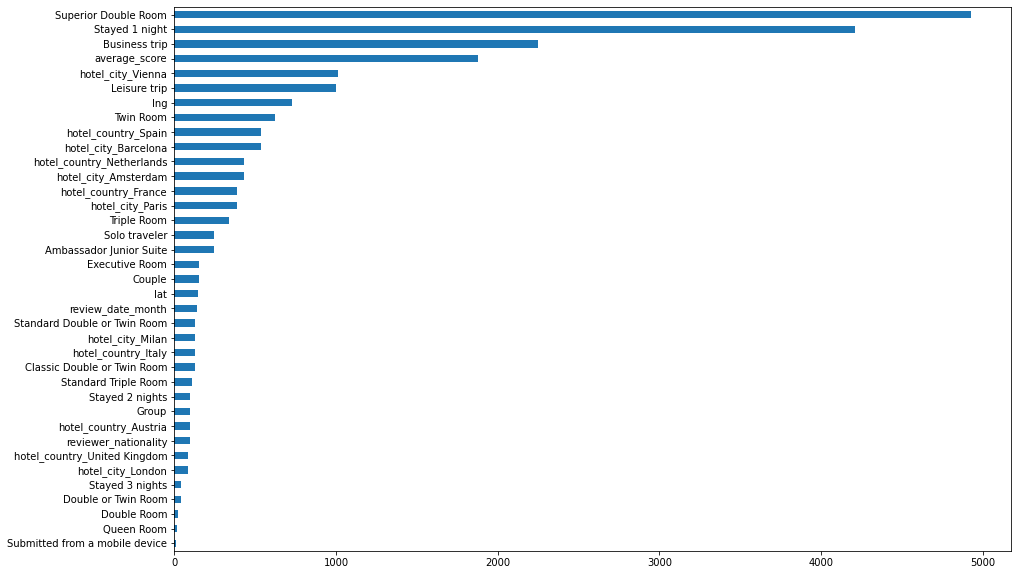

In [35]:
from sklearn.feature_selection import chi2 # хи-квадрат

# для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат.
# выведем значения хи-квадрат на графике:

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min()
X = X.drop(['lng'], axis=1)

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

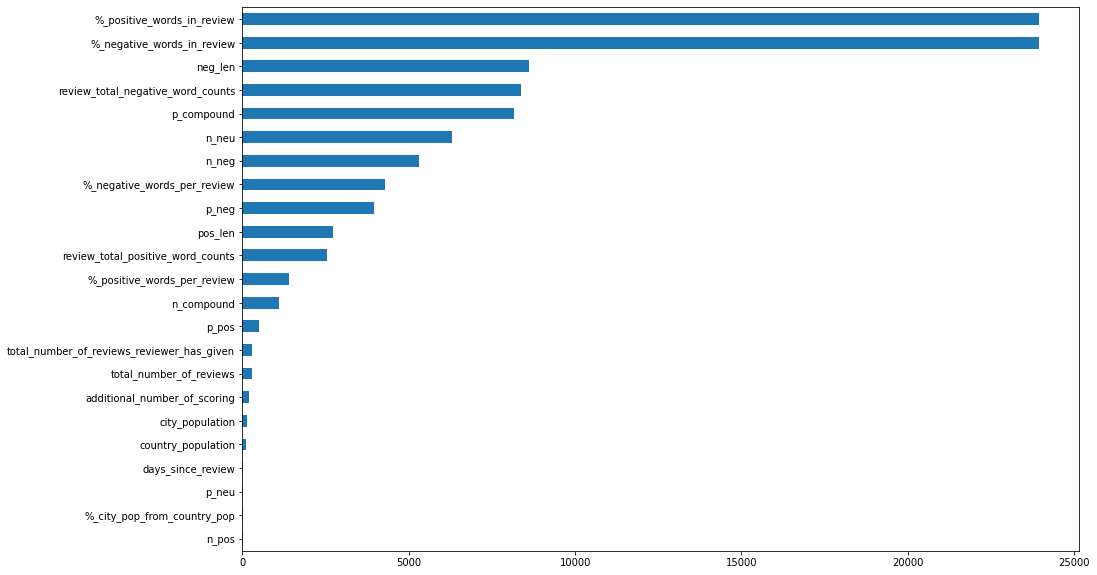

In [36]:
from sklearn.feature_selection import f_classif # anova
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.
# В основе метода оценки значимости переменных лежит анализ (ANOVA).
# В качестве меры значимости будем использовать значение f-статистики - чем значение статистики выше, тем меньше 
# вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

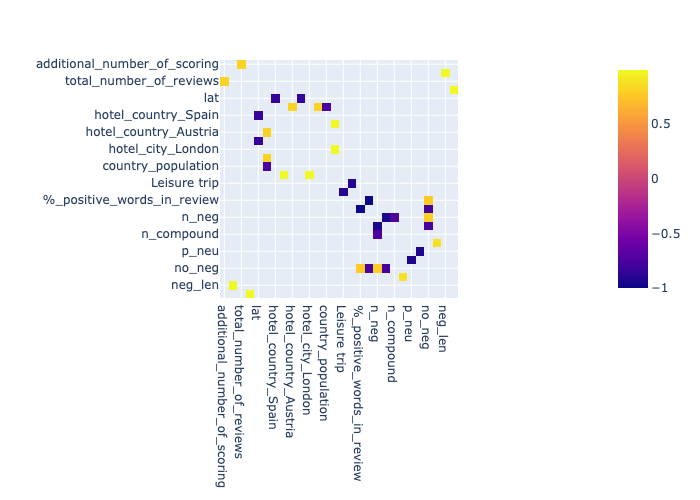

Deleted 14 columns


In [37]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующие с другими признаками
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)
fig.show("png")

# постараемся удалить минимальное количество признаков - удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = data.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

<AxesSubplot:>

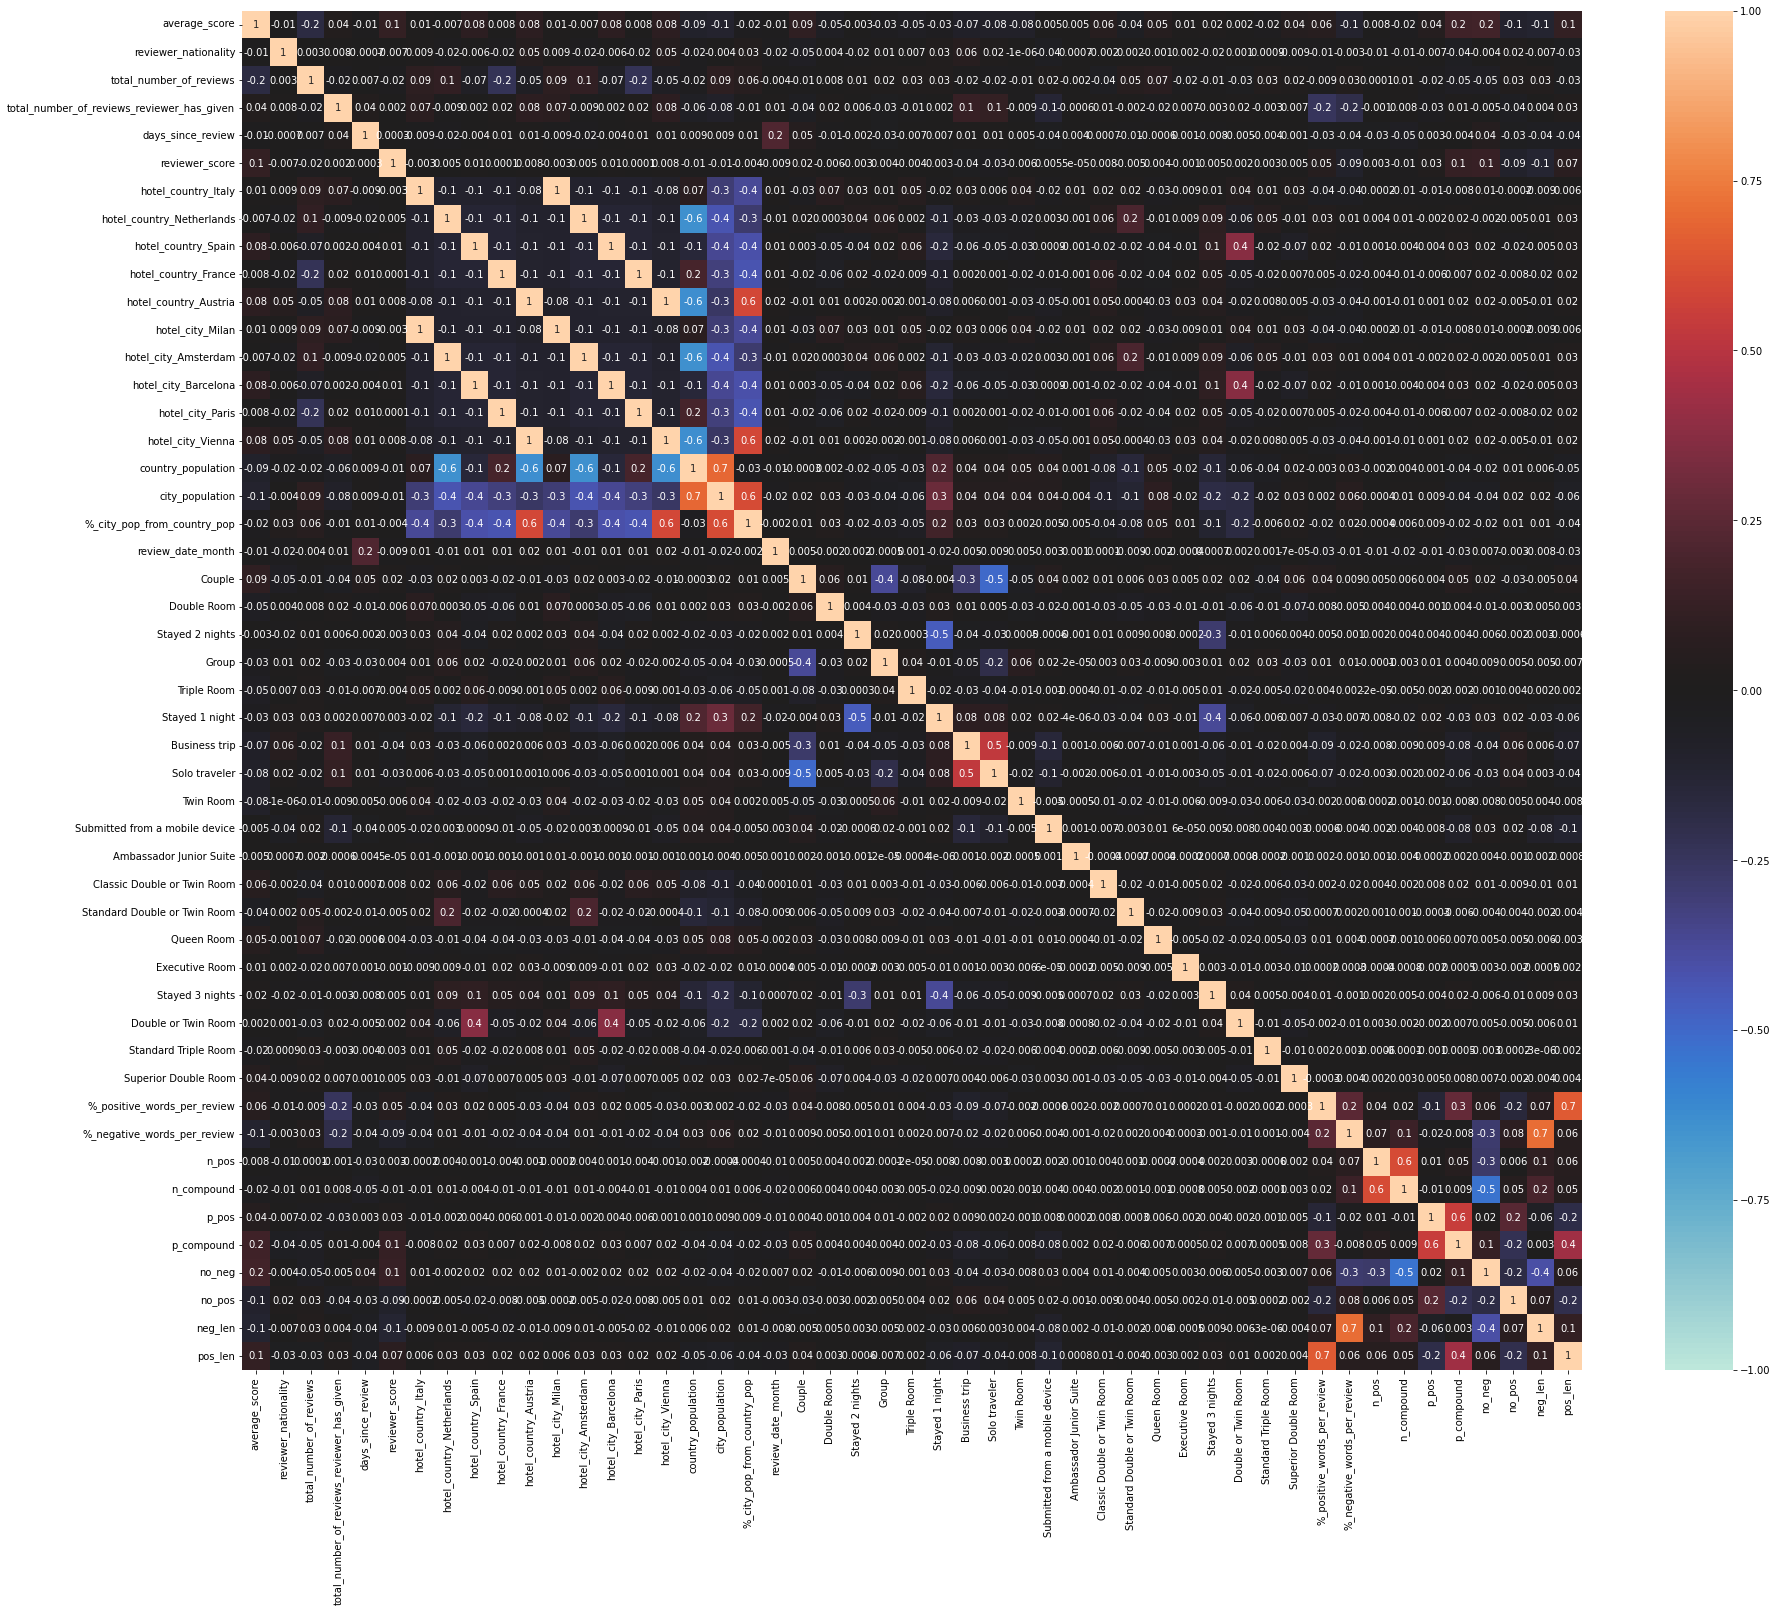

In [36]:
# проверяем тепловую карту корреляции на предмет оставших сильно скоррелированных признаков
plt.rcParams['figure.figsize'] = (30,25)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True, vmin=-1, vmax=1, center= 0, fmt='.1g')

Видим, что датасет очищен от сильно скоррелированных признаков. Можно готовить данные для обучения модели

## Готовим данные для модели

In [37]:
# теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [38]:
# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [39]:
# проверяем размерности получившихся датасетов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 49), (386803, 49), (386803, 48), (309442, 48), (77361, 48))

## Создаем и обучаем модель

In [40]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [41]:
# обучаем модель
model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [42]:
# пишем свою функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8572421762903786
MAPE: 12.179995818827784


<AxesSubplot:>

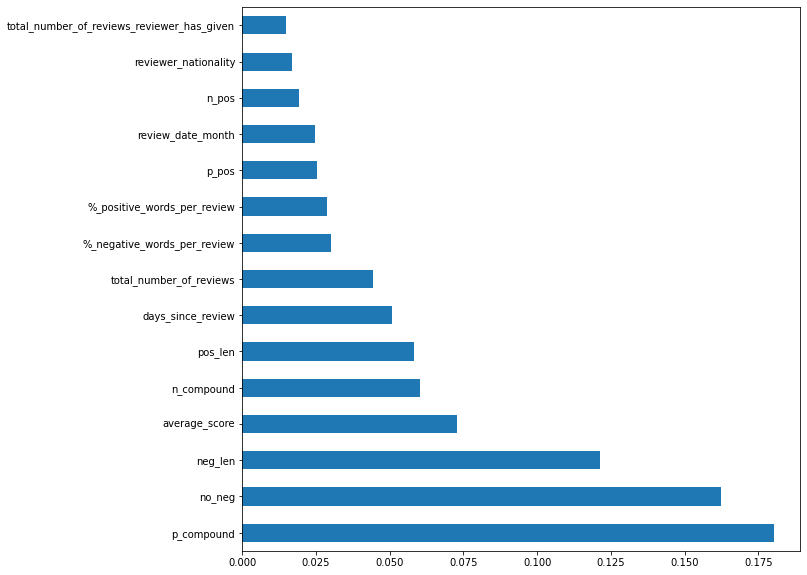

In [44]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [45]:
test_data.sample(3)

,average_score,reviewer_nationality,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_France,...,%_positive_words_per_review,%_negative_words_per_review,n_pos,n_compound,p_pos,p_compound,no_neg,no_pos,neg_len,pos_len
113848,8.7,1,315,9,110,0.0,0,0,0,1,...,0.888889,0.222222,0.000,0.000,0.381,0.5719,1,0,0,59
19785,9.2,8,945,11,178,0.0,0,0,0,0,...,2.727273,0.636364,0.000,0.000,0.089,0.3716,1,0,0,162
48923,8.6,10,4153,1,711,0.0,0,0,1,0,...,36.000000,9.000000,0.612,0.836,0.193,0.7776,0,0,48,172


In [46]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [47]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [48]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [49]:
predict_submission

array([8.352, 6.937, 8.156, ..., 7.934, 9.551, 7.178])

In [50]:
list(sample_submission)

['reviewer_score', 'id']

In [51]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_13.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.352,488440
1,6.937,274649
2,8.156,374688
3,9.731,404352
4,9.460,451596
5,8.787,302161
6,7.539,317079
7,7.457,13963
8,8.624,159785
9,7.643,195089
